<a href="https://colab.research.google.com/github/yunjai/Final_Proposal/blob/main/LSTM_%EC%8B%A4%ED%97%981_14_0_10%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
#print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available())

C:\Users\znld3\anaconda3\envs\gpu-14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\znld3\anaconda3\envs\gpu-14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\znld3\anaconda3\envs\gpu-14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\znld3\anaconda3\envs\gpu-14\lib\site-packages\tensorflow\pyth

True


In [ ]:
print(tf.__version__)

1.14.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#data = pd.read_csv('042622_summer.csv',parse_dates=['date'],index_col='date')
data = pd.read_csv('042722_yunjae.csv')#,parse_dates=['date'],index_col='date')

In [ ]:
## 결측치 확인
print(' 결측치 확인 : \n', data.isna().sum(),'\n')

 결측치 확인 : 
 temp                0
windspeed           0
winddirection       0
humidity            0
C                   0
hPa                 0
hr                  0
MJ                  0
cloud               0
visibility          0
surface             0
consumption-diff    0
Year                0
Month               0
Day                 0
Hour                0
consumption         0
dtype: int64 



In [ ]:
# 정규화 함수 
def MinMaxScaler(data):
    denom = np.max(data,0)-np.min(data,0)
    nume = data-np.min(data,0)
    return nume/denom

# 정규화 되돌리기 함수 
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back 

In [ ]:
data2 = data.to_numpy()
data3 = MinMaxScaler(data2)

In [ ]:
seqLength = 240 # 데이터 몇개로 예측할지 -> 168개로 다음 1시간 예측

trainSize = int(len(data3)*0.9)
valSize = int(len(data3)*0.8)

trainSet = data3[0:valSize]
valSet = data3[valSize:trainSize]
testSet = data3[trainSize:]

In [ ]:
print(trainSet.shape)
print(valSet.shape)
print(testSet.shape)

(21054, 17)
(2632, 17)
(2632, 17)


In [ ]:
def buildDataSet(timeSeries, seqLength):
    xdata = []
    ydata = [] 
    for i in range(len(timeSeries) - seqLength-24):
        tx = timeSeries[i:i+seqLength ,:-1] ## 모든 값
        ty = timeSeries[i+seqLength,[-1]] ## 맨끝값만
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [ ]:
trainX, trainY = buildDataSet(trainSet, seqLength)
testX, testY = buildDataSet(testSet, seqLength)
valX, valY = buildDataSet(valSet, seqLength)

In [ ]:
print(trainX.shape, trainY.shape)

(20790, 240, 16) (20790, 1)


In [ ]:
print(testX.shape, testY.shape)

(2368, 240, 16) (2368, 1)


In [ ]:
print(valX.shape, valY.shape)

(2368, 240, 16) (2368, 1)


In [ ]:
# 모델 설정하기
model = Sequential()
model.add(LSTM(units=128, input_shape=[seqLength,16],return_sequences = True, activation='tanh'))
model.add(LSTM(units=128,activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 240, 128)          74240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 205,953
Trainable params: 205,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlystopping = EarlyStopping(monitor='loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

In [ ]:
# 모델 학습과정 설정 
#adam = optimizers.Adam('learning_rate'==0.001)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
# 모델 트레이닝 
hist = model.fit(trainX, trainY, epochs=50, batch_size=16, callbacks=[earlystopping], validation_data=(valX, valY))

Train on 20790 samples, validate on 2368 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
20790/20790 [==============================] - 745s 36ms/sample - loss: 0.0169 - mean_absolute_error: 0.0963 - val_loss: 0.0148 - val_mean_absolute_error: 0.0920
Epoch 2/50
20790/20790 [==============================] - 740s 36ms/sample - loss: 0.0114 - mean_absolute_error: 0.0766 - val_loss: 0.0132 - val_mean_absolute_error: 0.0856
Epoch 3/50
20790/20790 [==============================] - 742s 36ms/sample - loss: 0.0111 - mean_absolute_error: 0.0753 - val_loss: 0.0347 - val_mean_absolute_error: 0.1455
Epoch 4/50
20790/20790 [==============================] - 740s 36ms/sample - loss: 0.0100 - mean_absolute_error: 0.0715 - val_loss: 0.0162 - val_mean_absolute_error: 0.0937
Epoch 5/50
20790/20790 [==============================] - 742s 36ms/sample - loss: 0.0095 - mean_absolute_error: 0.0694 - val_loss: 0.0137 - val_mean_absolute_error:

20790/20790 [==============================] - 761s 37ms/sample - loss: 3.7199e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0061 - val_mean_absolute_error: 0.0556
Epoch 46/50
20790/20790 [==============================] - 761s 37ms/sample - loss: 3.6587e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0080 - val_mean_absolute_error: 0.0645
Epoch 47/50
20790/20790 [==============================] - 759s 36ms/sample - loss: 3.4256e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0070 - val_mean_absolute_error: 0.0620
Epoch 48/50
20790/20790 [==============================] - 760s 37ms/sample - loss: 3.3205e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0070 - val_mean_absolute_error: 0.0609
Epoch 49/50
20790/20790 [==============================] - 761s 37ms/sample - loss: 3.3880e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0072 - val_mean_absolute_error: 0.0618
Epoch 50/50
20790/20790 [==============================] - 754s 36ms/sample - loss: 3.0899e-04 - mean_absolute_error: 0.01

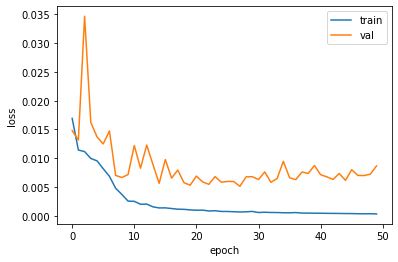

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [ ]:
# 모델 테스트 
res = model.evaluate(testX, testY, batch_size=16)
print("mse",res[0],"mae",res[1])

2368/2368 [==============================] - 43s 18ms/sample - loss: 0.0028 - mean_absolute_error: 0.0386
mse 0.0028317320096952294 mae 0.038574874


In [ ]:
actual = testY#.reshape(2440,24)

In [ ]:
# 모델 사용
predict = model.predict(testX)
predict.shape
print("Evaluate : {}".format(np.average((predict - actual)**2)))

Evaluate : 0.0028317319579332636


In [ ]:
predict.shape

(2368, 1)

In [ ]:
actual.shape

(2368, 1)

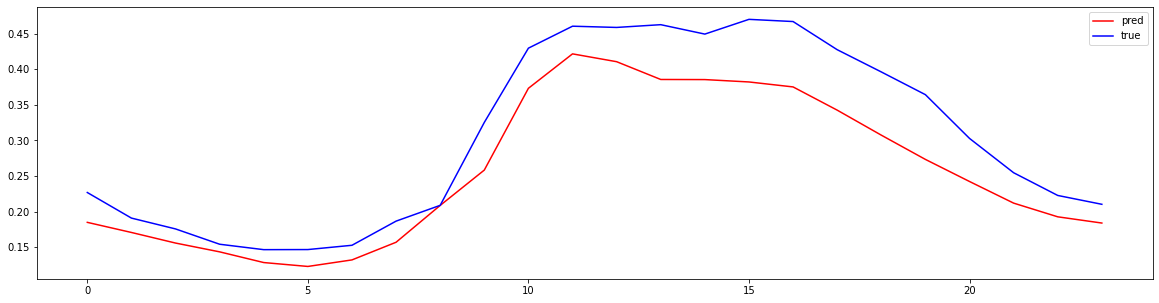

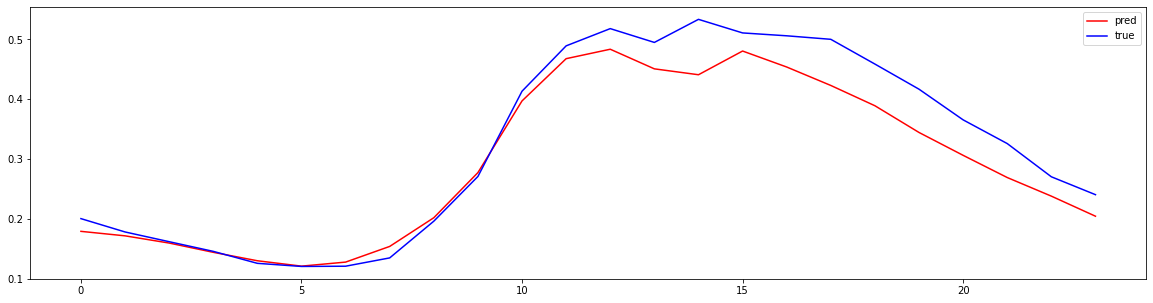

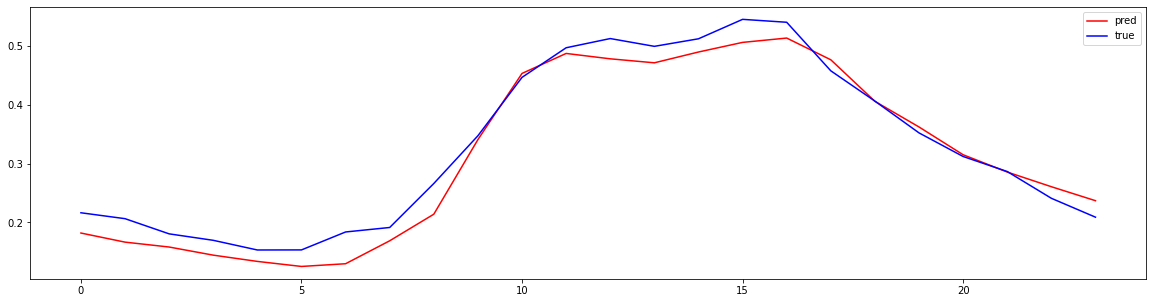

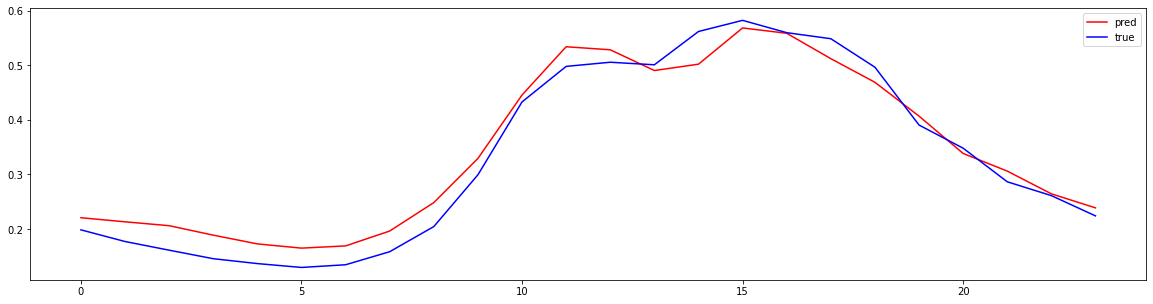

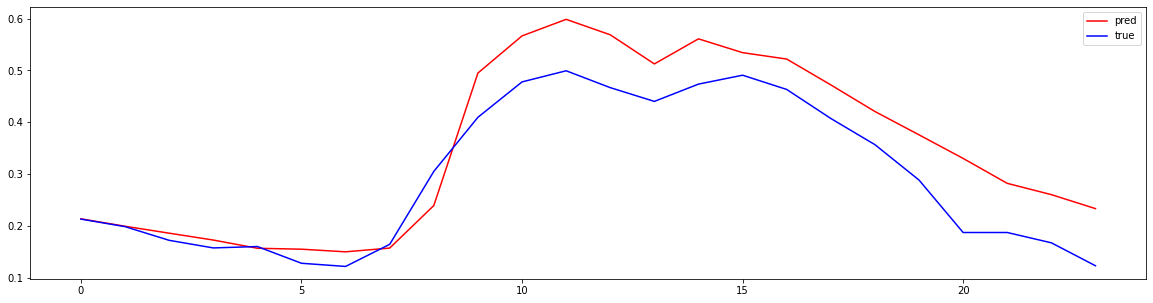

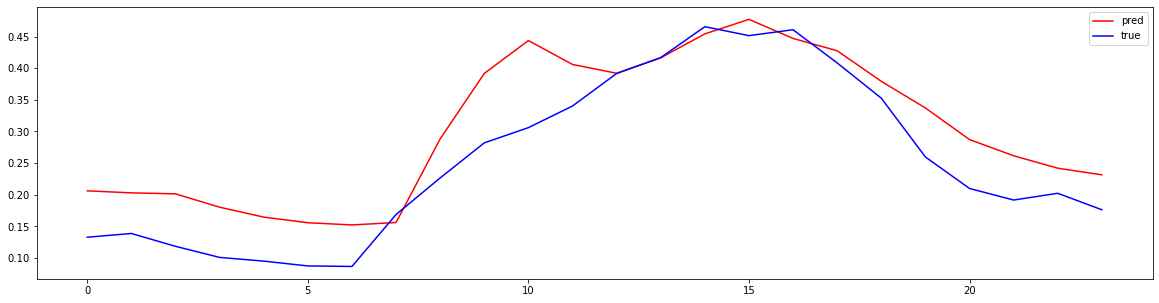

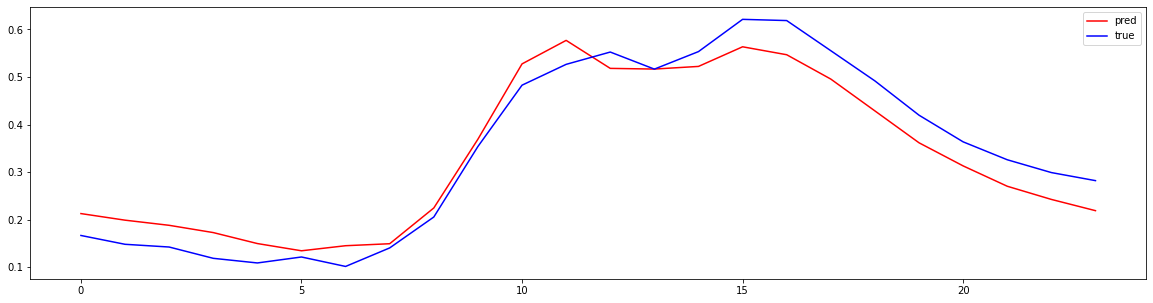

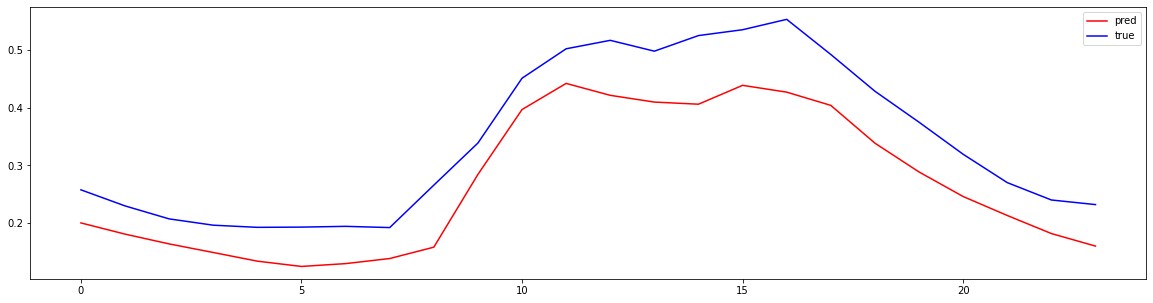

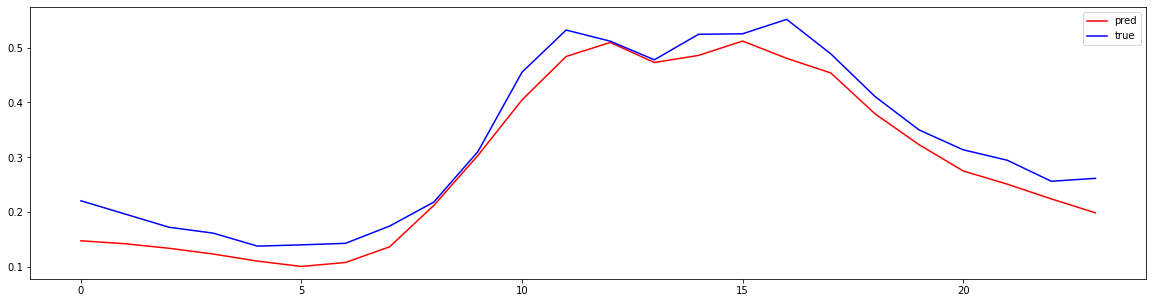

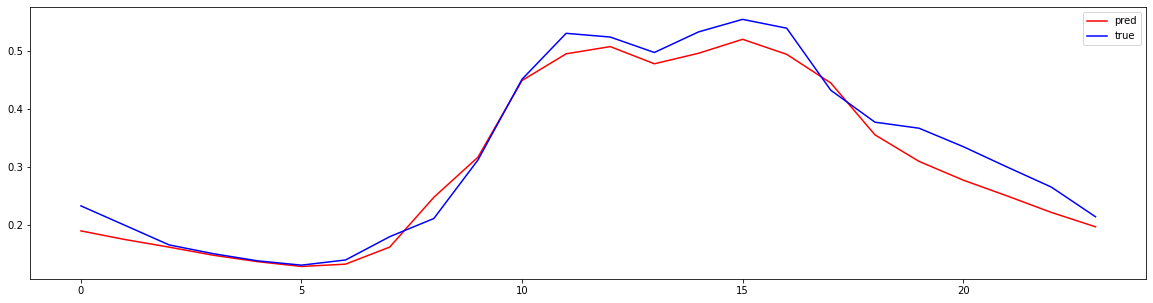

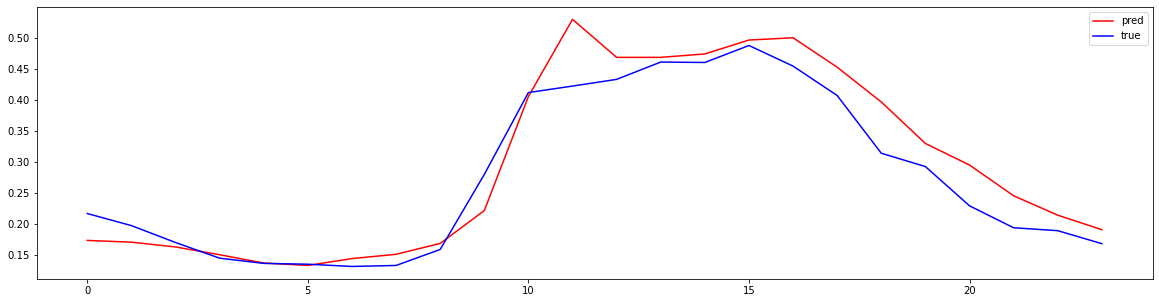

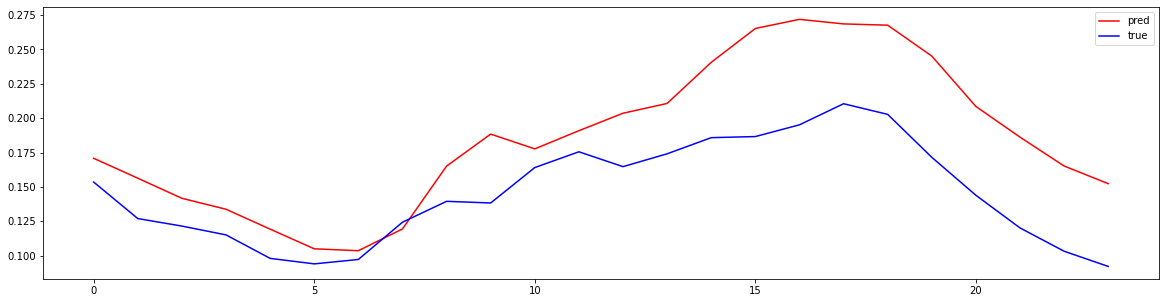

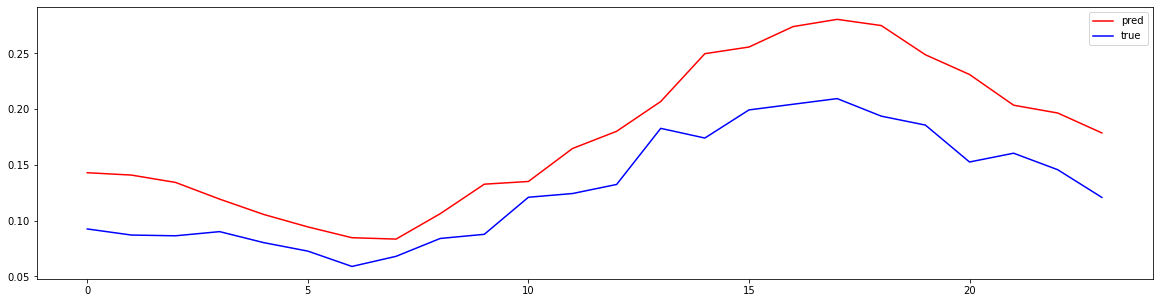

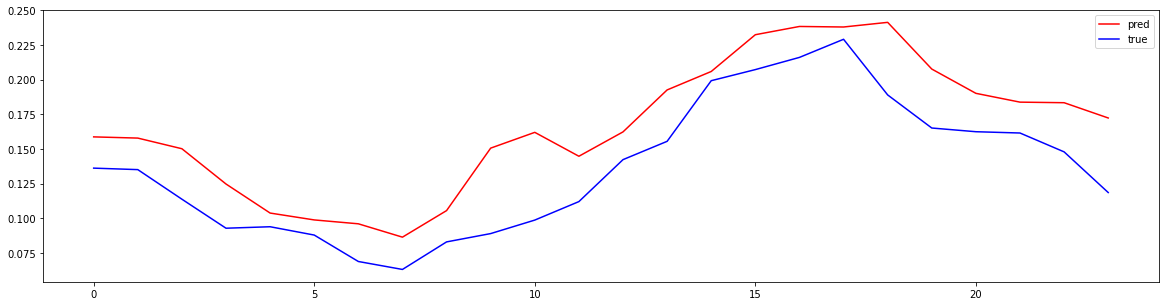

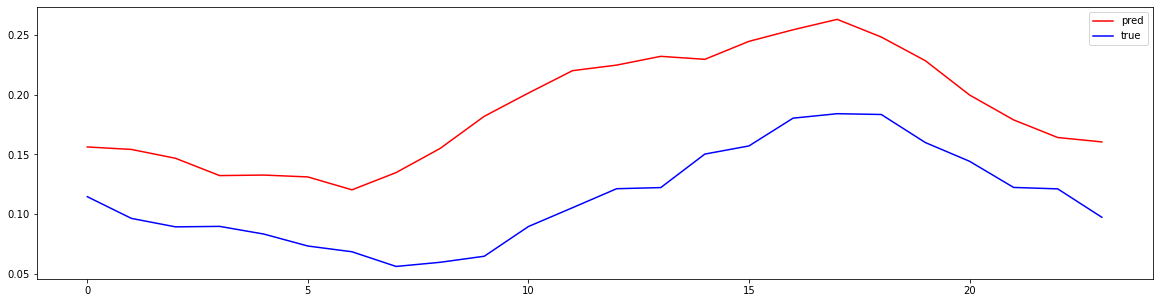

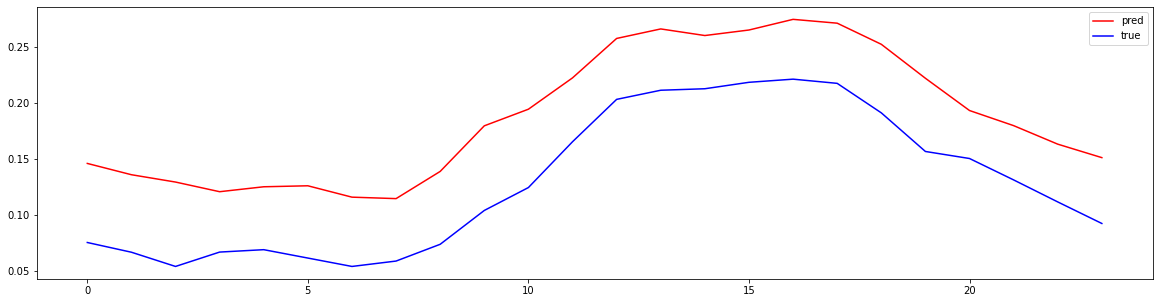

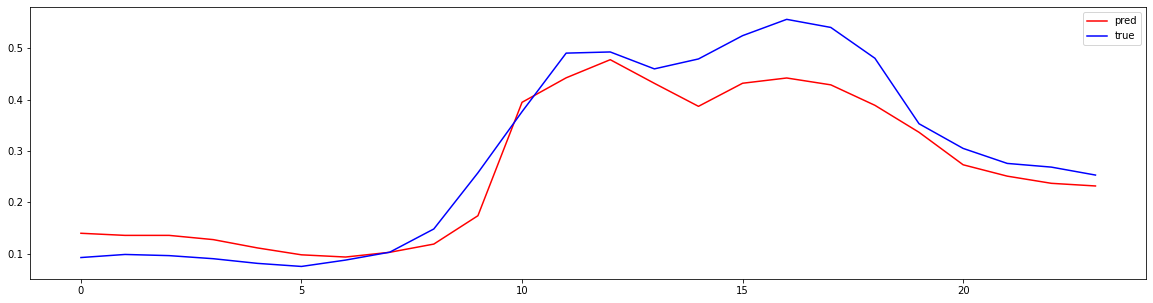

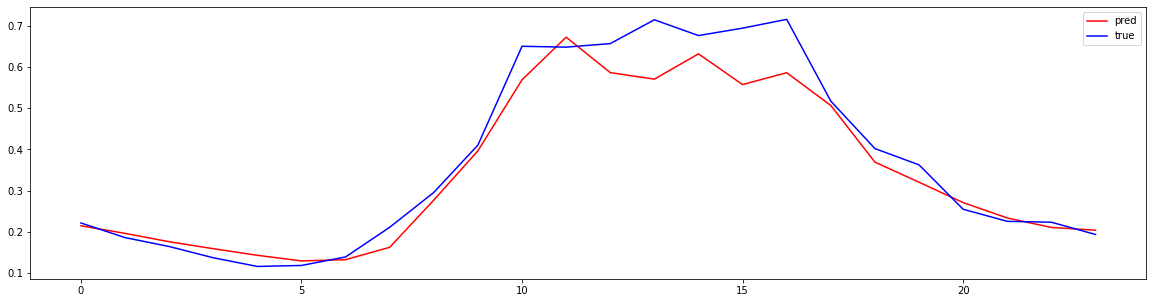

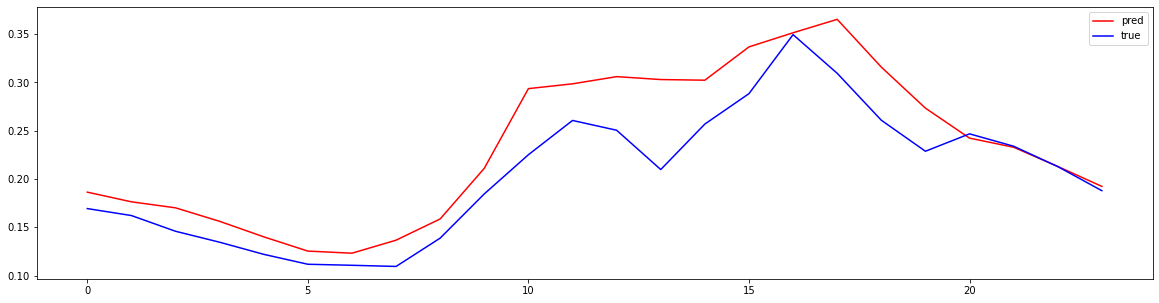

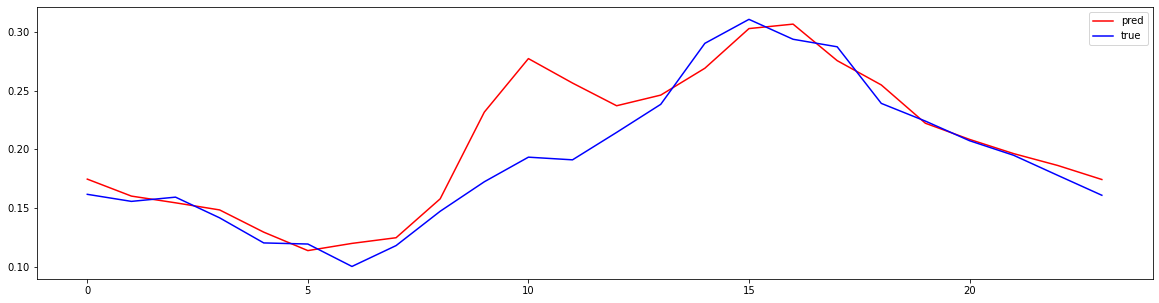

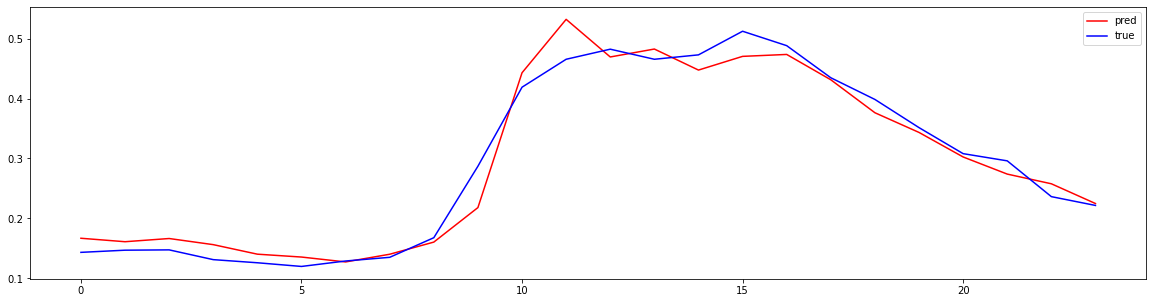

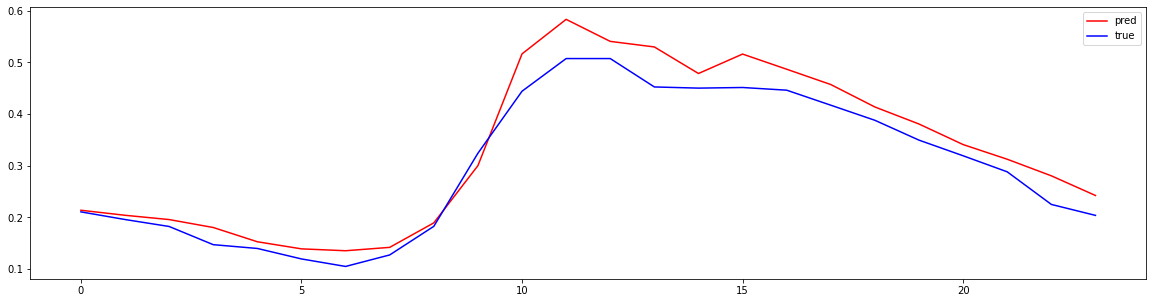

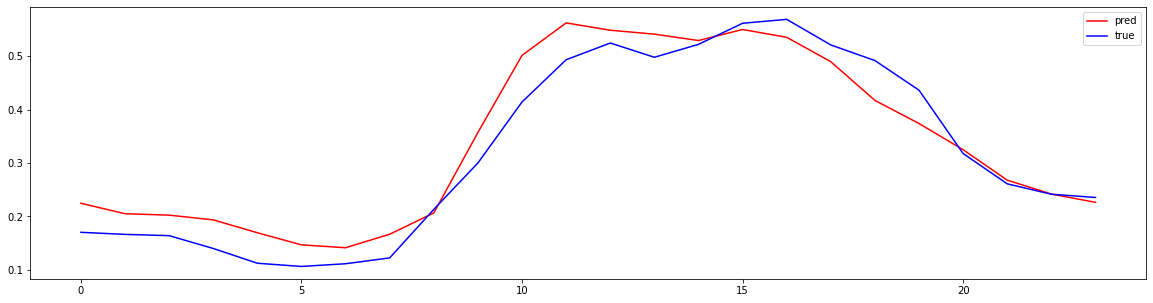

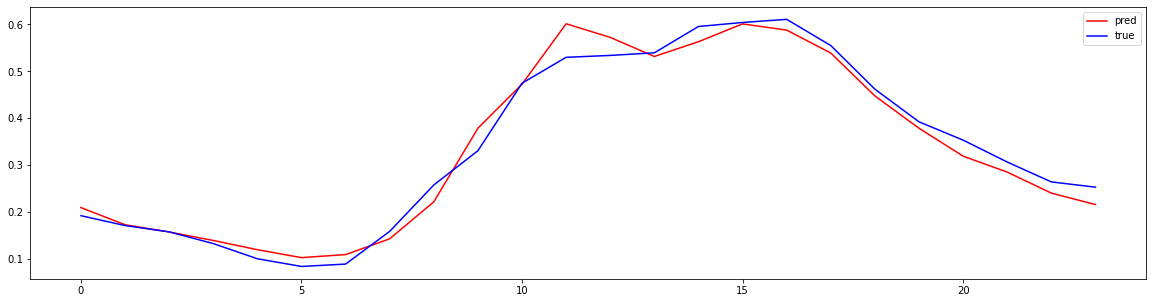

In [ ]:
for i in range(0,24):
    plt.figure(figsize=(20,5))
    plt.plot(predict[i*24:(i+1)*24,0],color='red',label='pred')
    plt.plot(actual[i*24:(i+1)*24,0],color='blue',label='true')
    plt.legend()
    plt.show()

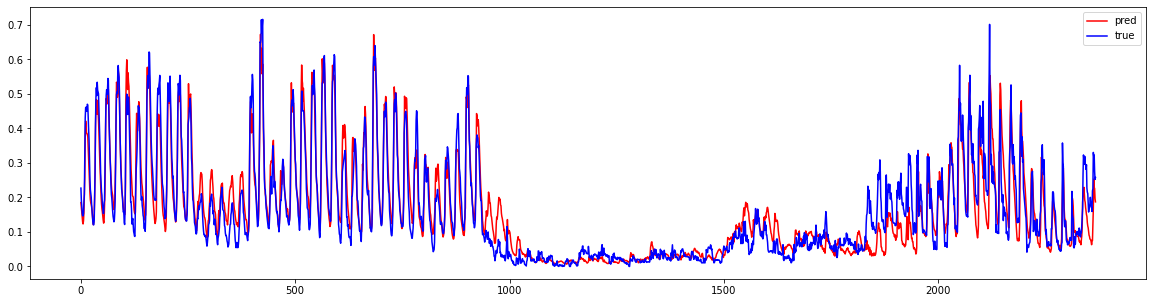

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(predict,color='red',label='pred')
plt.plot(actual,color='blue',label='true')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import explained_variance_score
print('explained_variance_score : ', explained_variance_score(actual, predict))

from sklearn.metrics import mean_absolute_error
print('mean_absolute_error : ', mean_absolute_error(actual, predict))

from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(actual, predict))

# from sklearn.metrics import mean_squared_log_error
# print('mean_squared_log_error : ', mean_squared_log_error(actual, predict))

from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(actual, predict))

from sklearn.metrics import median_absolute_error
print('median_absolute_error : ', median_absolute_error(actual, predict))

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(actual, predict))

explained_variance_score :  0.8666765629614561
mean_absolute_error :  0.03857487704541245
mean_squared_error :  0.0028317319579332636
mean_absolute_percentage_error :  189153361477.68503
median_absolute_error :  0.02764362217714235
r2_score :  0.8665372716107655


In [ ]:
# 원래 값으로 되돌리기 
realpred = back_MinMax(data2[trainSize-seqLength:,[-1]],predict)
realactual = back_MinMax(data2[trainSize-seqLength:,[-1]],actual)
print("예측값",realpred.shape)
print("실제값",realactual.shape)

예측값 (2368, 1)
실제값 (2368, 1)


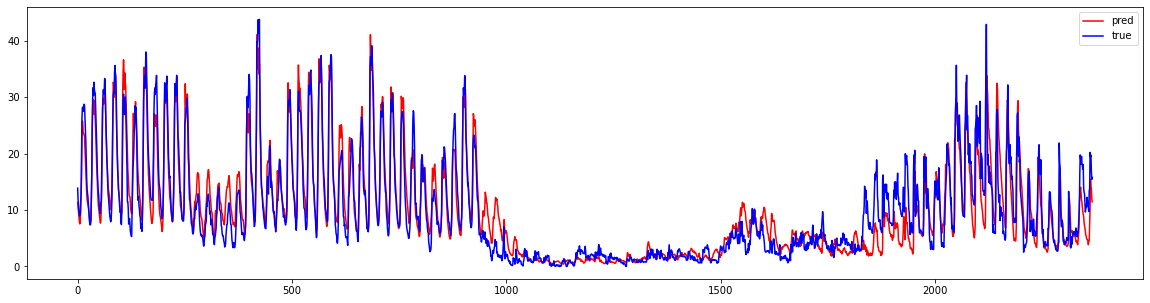

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(realpred,color='red',label='pred')
plt.plot(realactual,color='blue',label='true')
plt.legend()
plt.show()

In [ ]:
import shap

In [ ]:
tf.compat.v1.keras.backend.get_session(
    op_input_list=()
)

In [ ]:
explainer = shap.DeepExplainer(model, trainX[:10])

In [ ]:
shap_values = explainer.shap_values(testX[:10])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

In [ ]:
len(shap_values), shap_values[0].shape

(1, (10, 240, 16))

In [ ]:
col=data.columns.to_numpy()
features = col[:16]
features

array(['temp', 'windspeed', 'winddirection', 'humidity', 'C', 'hPa', 'hr',
       'MJ', 'cloud', 'visibility', 'surface', 'consumption-diff', 'Year',
       'Month', 'Day', 'Hour'], dtype=object)

In [ ]:
hoxy = np.array(shap_values)
hoxy = hoxy.reshape(-1,16)

In [ ]:
hoxy2 = testX[:10].reshape(-1,16)

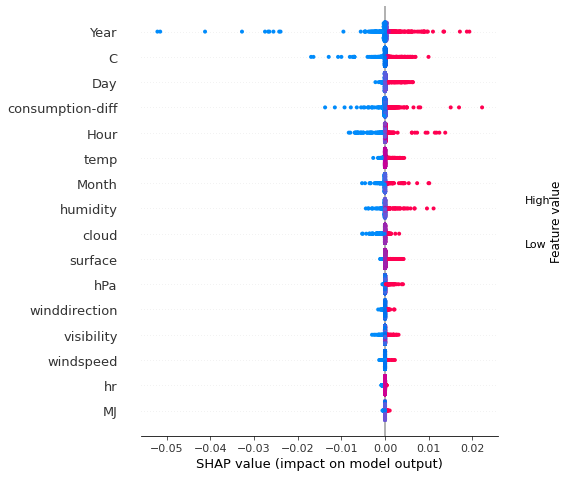

In [ ]:
shap.summary_plot(hoxy, hoxy, features)